In [10]:
import os
import numpy as np
import tensorflow as tf

from random import randint
import matplotlib.pyplot as plt

from crowdscan.loader.loader_eth import loadETH
from opentraj_benchmark.trajlet import split_trajectories

from tools.optimizer import CustomSchedule
from transformer.transformer import Transformer
from tools.trajectories import obs_pred_trajectories

In [17]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  


def evaluate(inp, Tpred):
    output = tf.expand_dims(inp[-1,:], 0)

    for i in range(Tpred):
        mask = create_look_ahead_mask(output.shape[0])
        predictions = transformer(inp, output, False, mask)
        prediction = tf.expand_dims(predictions[-1,:],0)
        output = tf.concat([output,prediction], axis = 0)

    return output

In [11]:
dataset_name = 'eth'

# Load dataset
dataset = []
if dataset_name == 'eth':
    # ETH
    root = './datasets/ETH/seq_eth/obsmat.txt'

    dataset = loadETH(root, title='ETH')

trajectories = dataset.get_trajectories()

N_t = len(trajectories)

#Take out the ones that have a total length less than 8s
short_trajs = []

for i in range(N_t):
    n = len(trajectories[i])
    # times = trajectories[i]["timestamp"].to_numpy()
    # length = times[n-1]-times[0]
    # if length < 8:
    #     short_trajs.append(i)
    if n < 20:
        short_trajs.append(i)

n = len(short_trajs)
for i in range(n):
    del trajectories[short_trajs[n-i-1]]

#Obtain trajlets from big trajectories
# trajectories = split_trajectories(trajectories, 8, 1)


#Number of frames in observed and predicted trajlets
Tobs = 8 #detect_separator(trajectories,3.2)
Tpred = 12 #len(trajectories[0])-Tobs


#Leave just the position information
for i in range(len(trajectories)):
    trajectories[i] = trajectories[i][['pos_x','pos_y']]

#Update the number of trajectories
N_t = len(trajectories)

#Obtain observed and predicted trajlets
Xm, Xp = obs_pred_trajectories(trajectories,Tobs,Tpred+Tobs)

Xm = tf.constant(Xm)
Xp = tf.constant(Xp)

Xm_ = []
Xp_ = []
for x in Xm:
    Xm_.append(x)
for x in Xp:
    Xp_.append(x)

Xm = Xm_
Xp = Xp_

In [12]:
d_model = 128
dff = 512

dropout_rate = 0.1

Latest checkpoint restored!!


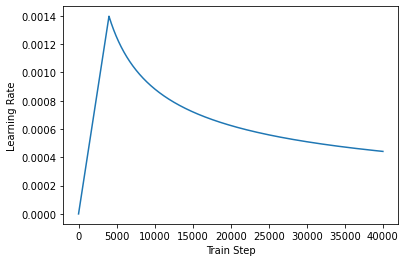

In [13]:
 learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
from_logits=True, reduction='none')

transformer = Transformer(d_model, dff, Tobs, Tpred, dropout_rate)

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


train_dataset = []
for i in range(len(Xp)):
    train_dataset.append((Xm[i],Xp[i]))

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

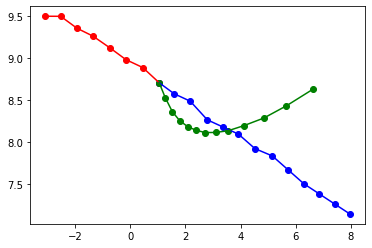

In [21]:
s = randint(0,(len(Xm)-1))
inp = Xm[s].numpy()
tar = Xp[s].numpy()
tar = np.concatenate([np.array([inp[-1]]),tar], axis = 0)
pred = evaluate(inp, Tpred).numpy()
plt.cla()
plt.plot(inp[:,0],inp[:,1], color = "red")
plt.scatter(inp[:,0],inp[:,1], color = "red")
plt.plot(tar[:,0],tar[:,1], color = "blue")
plt.scatter(tar[:,0],tar[:,1], color = "blue")
plt.plot(pred[:,0],pred[:,1], color = "green")
plt.scatter(pred[:,0],pred[:,1], color = "green")
plt.show()